In [2]:
%matplotlib inline
import numpy as np
import polars as pl
import pymc as pm
import arviz as az
from arviz import waic
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.filterwarnings("ignore", module="mkl_fft")
warnings.filterwarnings("ignore", module="matplotlib")

In [3]:
train = pl.read_csv('/home/john/BaseballHitters/Data/hitterstrain1620.csv').drop("PlayerName").rename({"Name": "player"})
test = pl.read_csv('/home/john/BaseballHitters/Data/hitters2021test.csv').rename({"Name": "player"})
RANDOM_SEED = 20090425

In [4]:
from scipy.special import expit

In [5]:
hitters_name = train.with_columns(pl.col("player").str.strip_chars().cast(pl.Categorical))
player = hitters_name['player'].to_physical().to_numpy()
player_str = hitters_name['player'].cat.get_categories()
train

shape: (1_803, 13)
┌──────┬─────────────────┬──────────┬────────────┬───┬───────────┬─────────┬─────────┬─────────┐
│      ┆ player          ┆ playerid ┆ birth_date ┆ … ┆ LA        ┆ Barrels ┆ maxEV   ┆ HardHit │
│ ---  ┆ ---             ┆ ---      ┆ ---        ┆   ┆ ---       ┆ ---     ┆ ---     ┆ ---     │
│ i64  ┆ str             ┆ i64      ┆ str        ┆   ┆ f64       ┆ i64     ┆ f64     ┆ i64     │
╞══════╪═════════════════╪══════════╪════════════╪═══╪═══════════╪═════════╪═════════╪═════════╡
│ 1    ┆ Trayce Thompson ┆ 9952     ┆ 1991-03-15 ┆ … ┆ 18.714962 ┆ 4       ┆ 110.307 ┆ 26      │
│ 2    ┆ Trayce Thompson ┆ 9952     ┆ 1991-03-15 ┆ … ┆ 7.6135    ┆ 1       ┆ 110.308 ┆ 13      │
│ 3    ┆ Trayce Thompson ┆ 9952     ┆ 1991-03-15 ┆ … ┆ 8.53471   ┆ 17      ┆ 110.185 ┆ 60      │
│ 4    ┆ Mike Trout      ┆ 10155    ┆ 1991-08-07 ┆ … ┆ 23.056103 ┆ 22      ┆ 112.865 ┆ 81      │
│ 5    ┆ Mike Trout      ┆ 10155    ┆ 1991-08-07 ┆ … ┆ 22.209169 ┆ 62      ┆ 116.6   ┆ 155     │
│ …    ┆ …               ┆ …        ┆ …          ┆ … ┆ …         ┆ …       ┆ …       ┆ …       │
│ 1799 ┆ Drew Butera     ┆ 3411     ┆ 1983-08-09 ┆ … ┆ 22.430912 ┆ 0       ┆ 99.4264 ┆ 5       │
│ 1800 ┆ Drew Butera     ┆ 3411     ┆ 1983-08-09 ┆ … ┆ 23.9      ┆ 0       ┆ 104.2   ┆ 6       │
│ 1801 ┆ Drew Butera     ┆ 3411     ┆ 1983-08-09 ┆ … ┆ 18.423804 ┆ 2       ┆ 103.685 ┆ 33      │
│ 1802 ┆ Drew Butera     ┆ 3411     ┆ 1983-08-09 ┆ … ┆ 18.588491 ┆ 0       ┆ 103.374 ┆ 30      │
│ 1803 ┆ Drew Butera     ┆ 3411     ┆ 1983-08-09 ┆ … ┆ 12.898012 ┆ 4       ┆ 102.653 ┆ 19      │
└──────┴─────────────────┴──────────┴────────────┴───┴───────────┴─────────┴─────────┴─────────┘

In [6]:
PA = train['PA'].to_numpy()
EV = train['EV'].to_numpy()
LA = train['LA'].to_numpy()
#OBP = train['OBP'].replace(0,1e-5).replace(1,.999999).to_numpy()
OBP = train['OBP'].to_numpy()
OBP_mean = OBP.mean()
OBP_sd = OBP.std()
OBP_center_scaled = (OBP - OBP_mean) / OBP_sd

In [125]:
#train.filter((pl.col("OBP") >.35) & (pl.col("PA") > 100)).unique().sort("OBP",descending = True).select("player")[0:10]
hitters_name_f = train.filter( (pl.col('PA') > 15)).with_columns(pl.col("player").str.strip_chars().cast(pl.Categorical)).rename({'player': 'player_f'})
player_f = hitters_name_f['player_f'].to_physical().to_numpy()
player_str_f = hitters_name_f['player_f'].cat.get_categories()
PA_f = train.filter( (pl.col('PA') > 15))['PA'].to_numpy()
EV_f = train.filter( (pl.col('PA') > 15))['EV'].to_numpy()
LA_f = train.filter( (pl.col('PA') > 15))['LA'].to_numpy()
OBP_f = train.filter( (pl.col('PA') > 15))['OBP'].to_numpy()
EV_player_f = train.filter( (pl.col('PA') > 15)).select("player","EV").group_by("player",maintain_order = True).mean()['EV'].to_numpy()
coords_f = {"player_f": player_str_f}
train.filter( (pl.col('PA') > 15))['OBP'].plot.hist()


:Histogram   [OBP]   (Count)

In [8]:
EV_player = train.select("player","EV").group_by("player",maintain_order = True).mean()['EV'].to_numpy()

In [9]:
# treating as a regression problem

In [10]:
coords = {"player":player_str}

In [ ]:
with pm.Model(coords = coords) as pooled_model:
    mu = pm.Normal('mu', 0, sigma=1e5)
    beta = pm.Normal('beta', mu=0, sigma=1e5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    theta = mu + beta*PA
    
    y = pm.Normal('y', theta, sigma=sigma, observed=OBP)
    

In [ ]:
pm.model_to_graphviz(pooled_model)

In [ ]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

In [ ]:
mu_mean = pooled_trace.posterior.mean(dim=("chain", "draw")).mu.values
beta_mean = pooled_trace.posterior.mean(dim=("chain", "draw")).beta.values


plt.scatter(train['PA'],train['OBP'])
xvals = np.linspace(0, 750)
plt.plot(xvals, beta_mean*xvals + mu_mean, 'r--');
plt.show()

In [ ]:
coords={'player': player_str}

with pm.Model(coords=coords) as unpooled_model:
    
    mu = pm.Normal('mu', 0, sigma=1e5, dims='player')
    beta = pm.Normal('beta', 0, sigma=1e5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    theta = mu[player] + beta*PA
    
    y = pm.Normal('y', theta, sigma=sigma, observed=OBP)
    

In [ ]:
pm.model_to_graphviz(unpooled_model)

In [ ]:
with unpooled_model:
    unpooled_trace = pm.sample(random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

In [ ]:
az.plot_forest(
    unpooled_trace, 
    var_names=['mu'], 
    ess=True, r_hat=True, 
    combined=True,
    figsize=(6,110),
    show = True
);

In [ ]:
unpooled_estimates = unpooled_trace.posterior.mean(dim=('chain', 'draw')).mu
unpooled_se = unpooled_trace.posterior.std(dim=('chain', 'draw')).mu

In [ ]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

unpooled_means_iter = unpooled_means.sortby("mu")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.mu)

_, ax = plt.subplots(figsize=(6,30))
yticks = np.arange(0, 507, 6)
unpooled_means_iter.plot.scatter(y="player", x="mu", ax=ax, alpha=0.8)
ax.hlines(
    np.arange(player_str.shape[0]),
    unpooled_hdi_iter.mu.sel(hdi="lower"),
    unpooled_hdi_iter.mu.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(xlabel="On Base Percentage (OBP)", ylim=(-1, 2))
ax.set_yticks(yticks)
ax.set_yticklabels(unpooled_means_iter.player.values[yticks])
ax.tick_params(rotation=45)
sns.despine(trim=True);
plt.show()

In [ ]:
sample_players = ("Juan Soto"
,"Freddie Freeman"
,"Mike Trout"
,"Joey Votto"
,"Mike Trout"
,"Mike Trout"
,"Mike Trout"
,"Mookie Betts"
,"Joey Votto"
,"Marcell Ozuna"
)


In [ ]:
with pm.Model(coords=coords) as partial_pooling:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    # Random intercepts
    mu = pm.Normal('mu', mu=mu_a, sigma=sigma_a, dims='player')
    
    # Model error
    sigma_y = pm.HalfCauchy('sigma_y',5)
    
    # Expected value
    y_hat = mu[player]
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=OBP)

In [ ]:
pm.model_to_graphviz(partial_pooling)

In [ ]:
with partial_pooling:
    partial_pooling_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

In [ ]:
with pm.Model(coords=coords) as varying_intercept:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e4)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    # Random intercepts
    mu = pm.Normal('mu', mu=mu_a, sigma=sigma_a, dims='player')
    # Common slope
    beta = pm.Normal('beta', mu=0., sigma=1e4)
    
    # Model error
    sd_y = pm.HalfCauchy('sd_y', 5)
    
    # Expected value
    y_hat = mu[player] + beta * PA
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sd_y, observed=OBP)
    

In [ ]:
pm.model_to_graphviz(varying_intercept)

In [ ]:
with varying_intercept:
    varying_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

In [ ]:
pm.plot_forest(varying_intercept_trace, var_names=['mu'], figsize=(6,110), combined=True, ess=True, r_hat=True,show = True);

In [ ]:
pm.plot_posterior(varying_intercept_trace, var_names=['sigma_a', 'beta'],show = True);

In [ ]:
az.summary(varying_intercept_trace, var_names=['beta'])

In [ ]:
with pm.Model(coords=coords) as varying_slope:
    # Priors
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e4)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # Common intercepts
    mu = pm.Normal('mu', mu=0., sigma=1e5)
    # Random Slopes
    beta = pm.Normal('beta', mu=mu_b, sigma=sigma_b, dims='player')
    
    # Model error
    sigma_y = pm.HalfCauchy('sigma_y', 5)
    
    # Expected value
    y_hat = mu + beta[player] * PA
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=OBP)
    
    varying_slope_trace = pm.sample( random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

In [ ]:
pm.model_to_graphviz(varying_slope)

pm.plot_forest(varying_slope_trace, var_names=['beta'], figsize=(6,110), combined=True, ess=True, r_hat=True,show = True);

In [ ]:
pm.plot_posterior(varying_slope_trace, var_names=['sigma_b', 'mu'],show = True);

In [ ]:
with pm.Model(coords=coords) as varying_slope_noncentered:
    
    # Priors
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # Common intercepts
    mu = pm.Normal('mu', mu=0., sigma=1e5)
    
    # Non-centered random slopes
    # Centered: b = pm.Normal('b', mu_b, sigma=sigma_b, shape=counties)
    z = pm.Normal('z', mu=0, sigma=1, dims='player')
    beta = pm.Deterministic("beta", mu_b + z * sigma_b, dims='player')
    
    # Model error
    sigma_y = pm.HalfCauchy('sigma_y',5)
    
    # Expected value
    y_hat = mu + beta[player] * PA
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=OBP)
    

In [ ]:
pm.model_to_graphviz(varying_slope_noncentered)

In [ ]:
with varying_slope_noncentered:
    varying_slope_noncentered_trace = pm.sample(tune=2000, target_accept=.9, random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

In [ ]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_slope_noncentered_trace.posterior.sel(chain=0)['sigma_b'], alpha=.5);
axs[0].set(ylabel='sigma_b');
axs[1].plot(varying_slope_noncentered_trace.posterior.sel(chain=0)['beta'], alpha=.05);
axs[1].set(ylabel='beta');
plt.show()

In [ ]:
x = varying_slope_noncentered_trace.posterior['beta'].sel(chain=0, player='Cole Tucker').to_series() 
x.name='slope'
y = varying_slope_noncentered_trace.posterior['sigma_b'].sel(chain=0).to_series()
y.name='slope group variance'

jp = sns.jointplot(x=x, y=y);
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, constrained_layout=True)
az.plot_posterior(varying_slope_trace, var_names=['sigma_b'], ax=ax1)
az.plot_posterior(varying_slope_noncentered_trace, var_names=['sigma_b'], ax=ax2)
ax1.set_title('Centered (top) and non-centered (bottom)');
plt.show()

In [ ]:
with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # Random intercepts
    mu = pm.Normal('mu', mu=mu_a, sigma=sigma_a, dims='player')
    # Random slopes
    beta = pm.Normal('beta', mu=mu_b, sigma=sigma_b, dims='player')
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = mu[player] + beta[player] * PA
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=OBP)

In [ ]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=4000, target_accept = .9, random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

In [ ]:
az.plot_forest(varying_intercept_slope_trace, var_names=['mu','beta'], figsize=(6,220), combined=True, ess=True, r_hat=True,show = True);

In [183]:
with pm.Model(coords=coords) as varying_intercept_noncentered:
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    
    # Random intercepts
    z_a = pm.Normal('z_a', mu=0, sigma=1, dims='player')
    mu = pm.Deterministic("mu", mu_a + z_a * sigma_a, dims='player')
    
    # common slopes
    beta = pm.Normal('beta', mu=0., sigma=1e4)
    
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = mu[player] + beta * PA
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=OBP)



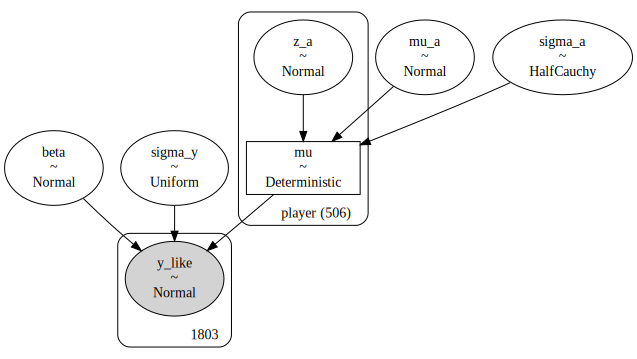

In [184]:
pm.model_to_graphviz(varying_intercept_noncentered)

In [185]:
with varying_intercept_noncentered:
    varying_intercept_noncentered_trace = pm.sample(random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, z_a, beta, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


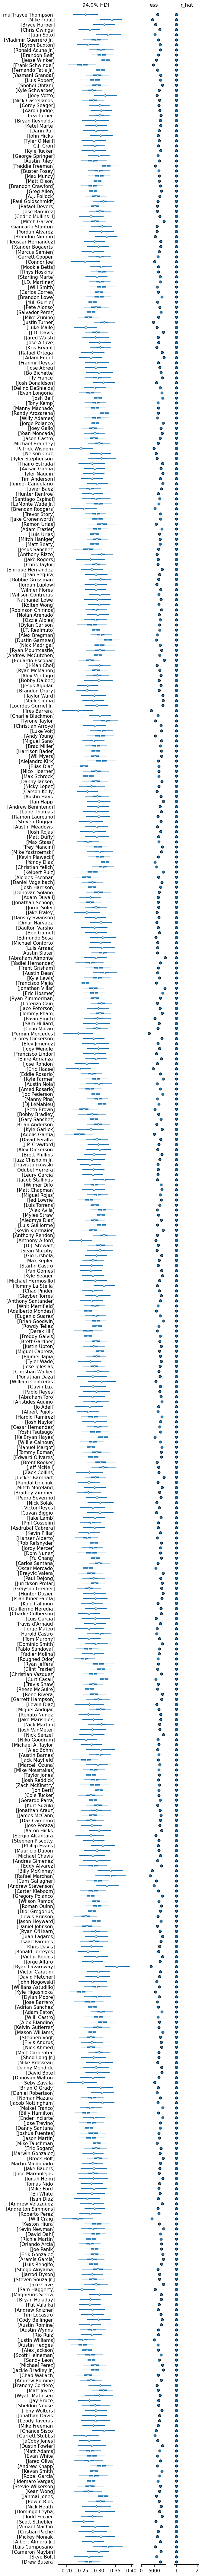

In [186]:
az.plot_forest(varying_intercept_noncentered_trace, var_names=['mu'], figsize=(6,110), combined=True, ess=True, r_hat=True,show = True);

In [ ]:
with pm.Model(coords=coords) as varying_intercept_slope_noncentered:
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # Random intercepts
    z_a = pm.Normal('z_a', mu=0, sigma=1, dims='player')
    mu = pm.Deterministic("mu", mu_a + z_a * sigma_a, dims='player')
    # Random slopes
    z_b = pm.Normal('z_b', mu=0, sigma=1, dims='player')
    beta = pm.Deterministic("beta", mu_b + z_b * sigma_b, dims='player')
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = mu[player] + beta[player] * PA
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=OBP)



In [ ]:
pm.model_to_graphviz(varying_intercept_slope_noncentered)

In [ ]:
with varying_intercept_slope_noncentered:
    varying_intercept_slope_noncentered_trace = pm.sample(random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

In [ ]:
az.plot_forest(varying_intercept_slope_noncentered_trace, var_names=['mu','beta'], figsize=(6,220), combined=True, ess=True, r_hat=True,show = True);

In [187]:
df_comp_loocv = az.compare({"Pooled Model": pooled_trace, "Unpooled Model": unpooled_trace, "Partial Pooling Model": partial_pooling_trace,
                            "Varying Intercept Model": varying_intercept_trace,"Varying Slope Model": varying_slope_trace, 
                            "Varying Intercept Noncentered Model": varying_intercept_noncentered_trace,"Varying Slope Noncentered Model": varying_slope_noncentered_trace, 
                            "Varying Intercept Slope Model": varying_intercept_slope_trace, 
                            "Varying Intercept Slope Noncentered Model": varying_intercept_slope_noncentered_trace})
df_comp_loocv

/home/john/miniconda3/envs/BaseballHitters/lib/python3.12/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/john/miniconda3/envs/BaseballHitters/lib/python3.12/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/john/miniconda3/

rank     elpd_loo       p_loo  \
Varying Intercept Slope Model                 0  2553.589098  229.546388   
Varying Intercept Noncentered Model           1  2553.544171  225.451453   
Varying Intercept Slope Noncentered Model     2  2552.176003  224.918027   
Varying Intercept Model                       3  2550.778518  226.541868   
Varying Slope Noncentered Model               4  2511.045199    8.033428   
Varying Slope Model                           5  2510.670697    8.782948   
Pooled Model                                  6  2510.638870    6.676342   
Partial Pooling Model                         7  2489.626149  299.885054   
Unpooled Model                                8  2434.405931  512.609410   

                                            elpd_diff        weight  \
Varying Intercept Slope Model                0.000000  1.237965e-14   
Varying Intercept Noncentered Model          0.044928  5.706073e-01   
Varying Intercept Slope Noncentered Model    1.413095  0.000000e+00   
Varying Intercept Model                      2.810581  0.000000e+00   
Varying Slope Noncentered Model             42.543900  1.053077e-15   
Varying Slope Model                         42.918402  2.464018e-15   
Pooled Model                                42.950228  2.166714e-01   
Partial Pooling Model                       63.962949  0.000000e+00   
Unpooled Model                             119.183168  2.127212e-01   

                                                  se        dse  warning scale  
Varying Intercept Slope Model              66.540716   0.000000     True   log  
Varying Intercept Noncentered Model        66.685159   1.023018     True   log  
Varying Intercept Slope Noncentered Model  66.681371   1.207364     True   log  
Varying Intercept Model                    66.923716   1.109643     True   log  
Varying Slope Noncentered Model            63.520248  11.085470    False   log  
Varying Slope Model                        63.493001  11.047632    False   log  
Pooled Model                               63.559014  11.140411    False   log  
Partial Pooling Model                      65.065860  13.361190     True   log  
Unpooled Model                             63.593396  34.627955     True   log

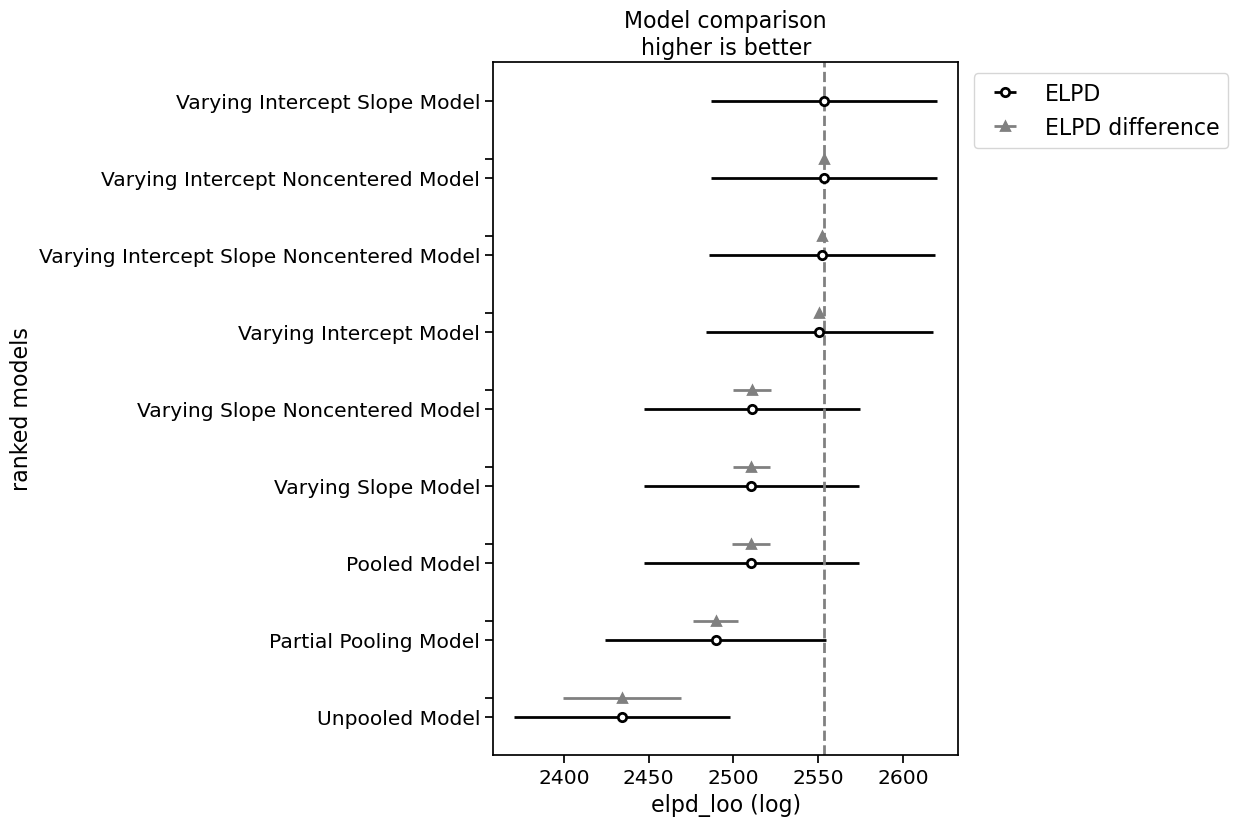

In [188]:
az.plot_compare(df_comp_loocv, insample_dev=False,show = True);

In [179]:
with pm.Model(coords=coords_f) as varying_intercept_noncentered_2:
    # Priors
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    #v_prior = pm.Gamma('v_prior',alpha = 1,beta = 30)
    
     # EV model
    gamma_0 = pm.Normal('gamma_0', mu=0., sigma=1e5)
    gamma_1 = pm.Normal('gamma_1', mu=0., sigma=1e5)

    #EV model for intercept
    mu_a = pm.Deterministic('mu_a', gamma_0 + gamma_1*EV_player_f)
    
    # player variation not explained by EV
    z_a = pm.Normal('z_a', mu=0, sigma=1, dims='player_f')
    mu = pm.Deterministic("mu", mu_a + z_a * sigma_a, dims='player_f')
    
    # common slopes
    beta = pm.Normal('beta', mu=0., sigma=1e4)

    #nu
    #v = pm.Exponential('v', scale = v_prior)
    
    # Model error
    sigma_y = pm.InverseGamma('sigma_y',alpha = 1,beta = 1)#lower=0, upper=100)

    #a = pm.InverseGamma('a',alpha = 1,beta = 1)#lower=0, upper=100)
    #b = pm.InverseGamma('b',alpha = 1,beta = 1)#lower=0, upper=100)

    
    # Expected value
    y_hat = mu[player_f] + beta * LA_f
    
    # Data likelihood
    #y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=OBP_f)
    y_like = pm.StudentT('y_like',mu=y_hat, sigma=sigma_y, nu = 15,observed=OBP_f)




In [180]:
with varying_intercept_noncentered_2:
    varying_intercept_noncentered_trace_2 = pm.sample(tune = 1000,target_accept = 0.9,random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True},cores = 4)
    # Posterior predictive sampling
    idata = pm.sample_posterior_predictive(varying_intercept_noncentered_trace_2, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, gamma_0, gamma_1, z_a, beta, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.
Sampling: [y_like]


Output()

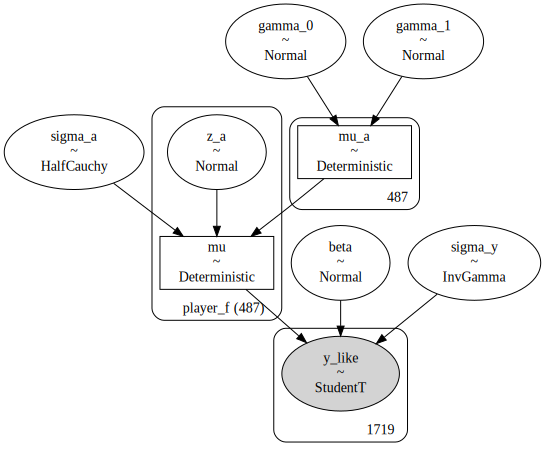

In [181]:
pm.model_to_graphviz(varying_intercept_noncentered_2)

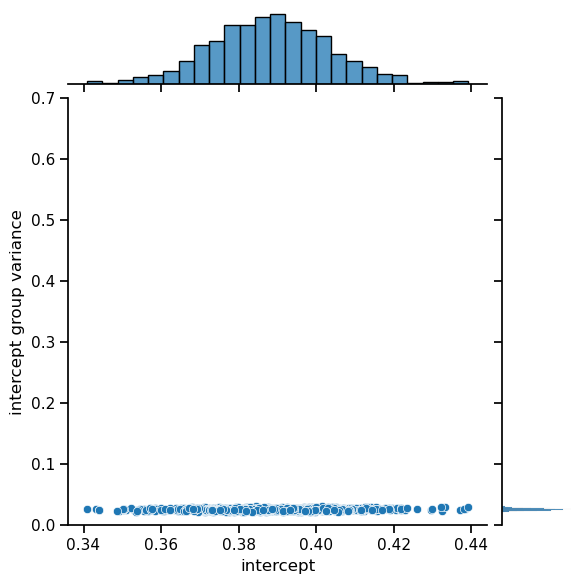

In [182]:
x = pl.Series('intercept', varying_intercept_noncentered_trace_2.posterior['mu'].sel(chain=0)[:,2].to_numpy())
y = pl.Series('intercept group variance', varying_intercept_noncentered_trace_2.posterior['sigma_a'].sel(chain=0).to_numpy())

sns.jointplot(x=x, y=y, ylim=(0, .7));
plt.show()

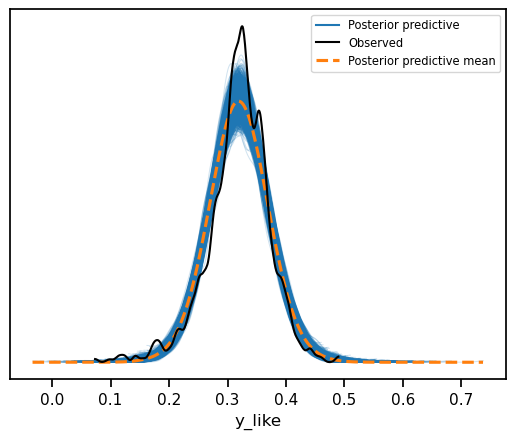

In [183]:
az.plot_ppc(varying_intercept_noncentered_trace_2,show = True);

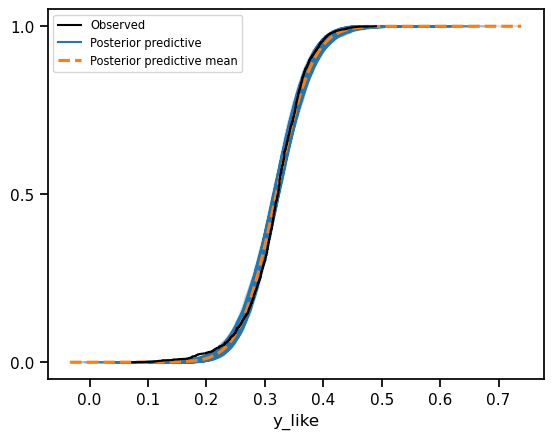

In [184]:
az.plot_ppc(varying_intercept_noncentered_trace_2, kind='cumulative',show = True);

In [185]:
az.loo( varying_intercept_noncentered_trace_2)

Computed from 4000 posterior samples and 1719 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  2860.68    40.45
p_loo      269.66        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1719  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

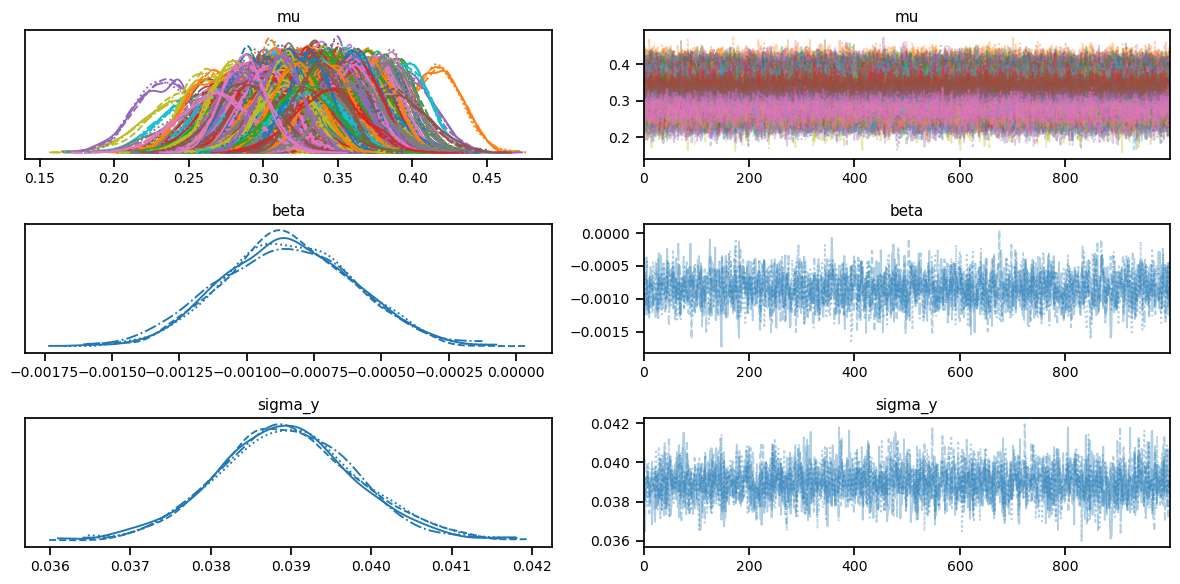

In [186]:
az.plot_trace(varying_intercept_noncentered_trace_2, var_names=['mu','beta','sigma_y'],legend = False);
plt.tight_layout();
plt.show()

In [187]:
post =  varying_intercept_noncentered_trace_2.posterior
#print(post)
az.extract(post)

<xarray.Dataset> Size: 47MB
Dimensions:     (sample: 4000, player_f: 487, mu_a_dim_0: 487)
Coordinates:
  * player_f    (player_f) <U21 41kB 'Trayce Thompson' ... 'Drew Butera'
  * mu_a_dim_0  (mu_a_dim_0) int64 4kB 0 1 2 3 4 5 6 ... 481 482 483 484 485 486
  * sample      (sample) object 32kB MultiIndex
  * chain       (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw        (sample) int64 32kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    beta        (sample) float64 32kB -0.001105 -0.0009457 ... -0.0006605
    gamma_0     (sample) float64 32kB -0.2253 -0.206 -0.2224 ... -0.2167 -0.3314
    gamma_1     (sample) float64 32kB 0.006291 0.00608 ... 0.006234 0.007466
    mu          (player_f, sample) float64 16MB 0.2597 0.2884 ... 0.2724 0.2973
    mu_a        (mu_a_dim_0, sample) float64 16MB 0.3249 0.3257 ... 0.3064
    sigma_a     (sample) float64 32kB 0.0257 0.02449 0.02464 ... 0.02867 0.02504
    sigma_y     (sample) float64 32kB 0.04057 0.03921 ... 0.03902 0.03936
    z_a         (player_f, sample) float64 16MB -2.538 -1.526 ... -1.517 -0.3652
Attributes:
    created_at:                 2024-08-01T19:41:02.025556+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.1
    sampling_time:              99.30793762207031
    tuning_steps:               1000

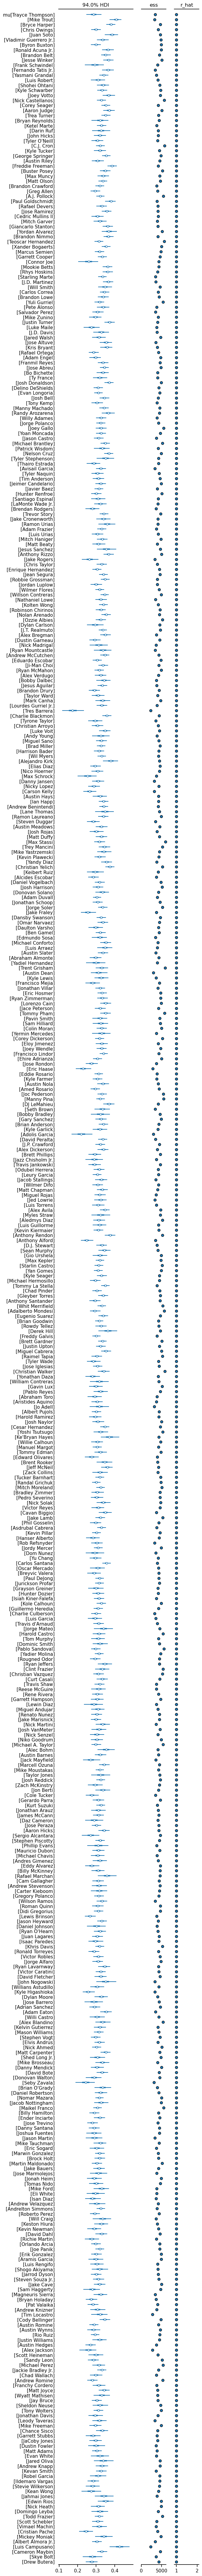

In [77]:
az.plot_forest(varying_intercept_noncentered_trace_2, var_names=['mu'], figsize=(6,110), combined=True, ess=True, r_hat=True,show = True);

In [76]:
varying_intercept_noncentered_trace_2.sample_stats

<xarray.Dataset> Size: 496kB
Dimensions:                (chain: 4, draw: 1000)
Coordinates:
  * chain                  (chain) int64 32B 0 1 2 3
  * draw                   (draw) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables: (12/17)
    acceptance_rate        (chain, draw) float64 32kB 0.8505 0.3777 ... 0.9627
    diverging              (chain, draw) bool 4kB False False ... False False
    energy                 (chain, draw) float64 32kB -1.917e+03 ... -1.981e+03
    energy_error           (chain, draw) float64 32kB 0.3121 0.3224 ... 0.05512
    index_in_trajectory    (chain, draw) int64 32kB 113 -269 167 ... -105 -129
    largest_eigval         (chain, draw) float64 32kB nan nan nan ... nan nan
    ...                     ...
    process_time_diff      (chain, draw) float64 32kB 0.04572 ... 0.04647
    reached_max_treedepth  (chain, draw) bool 4kB False False ... False False
    smallest_eigval        (chain, draw) float64 32kB nan nan nan ... nan nan
    step_size              (chain, draw) float64 32kB 0.01192 0.01192 ... 0.0104
    step_size_bar          (chain, draw) float64 32kB 0.01218 ... 0.01259
    tree_depth             (chain, draw) int64 32kB 8 9 8 9 9 9 ... 8 8 8 8 8 8
Attributes:
    created_at:                 2024-08-01T18:32:54.051908+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.1
    sampling_time:              146.45842480659485
    tuning_steps:               1000

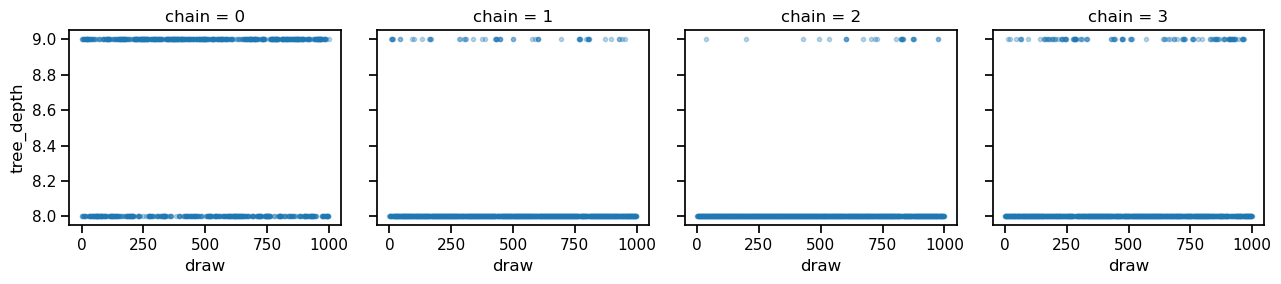

In [74]:
varying_intercept_noncentered_trace_2.sample_stats["tree_depth"].plot(col="chain", ls="none", marker=".", alpha=0.3);
plt.show()

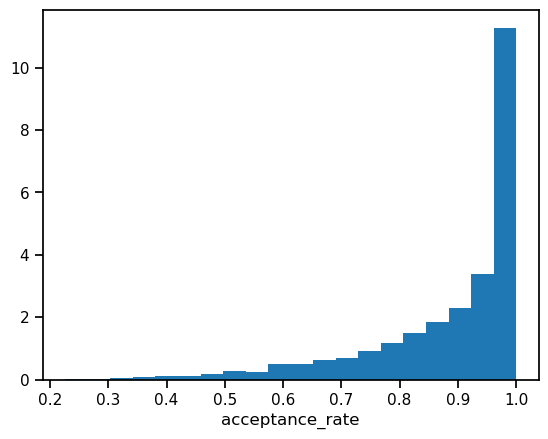

In [75]:
varying_intercept_noncentered_trace_2.sample_stats["acceptance_rate"].plot.hist(bins=20, density=True);
plt.show()

/home/john/miniconda3/envs/BaseballHitters/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1523) in plot_posterior, generating only 40 plots
  warnings.warn(


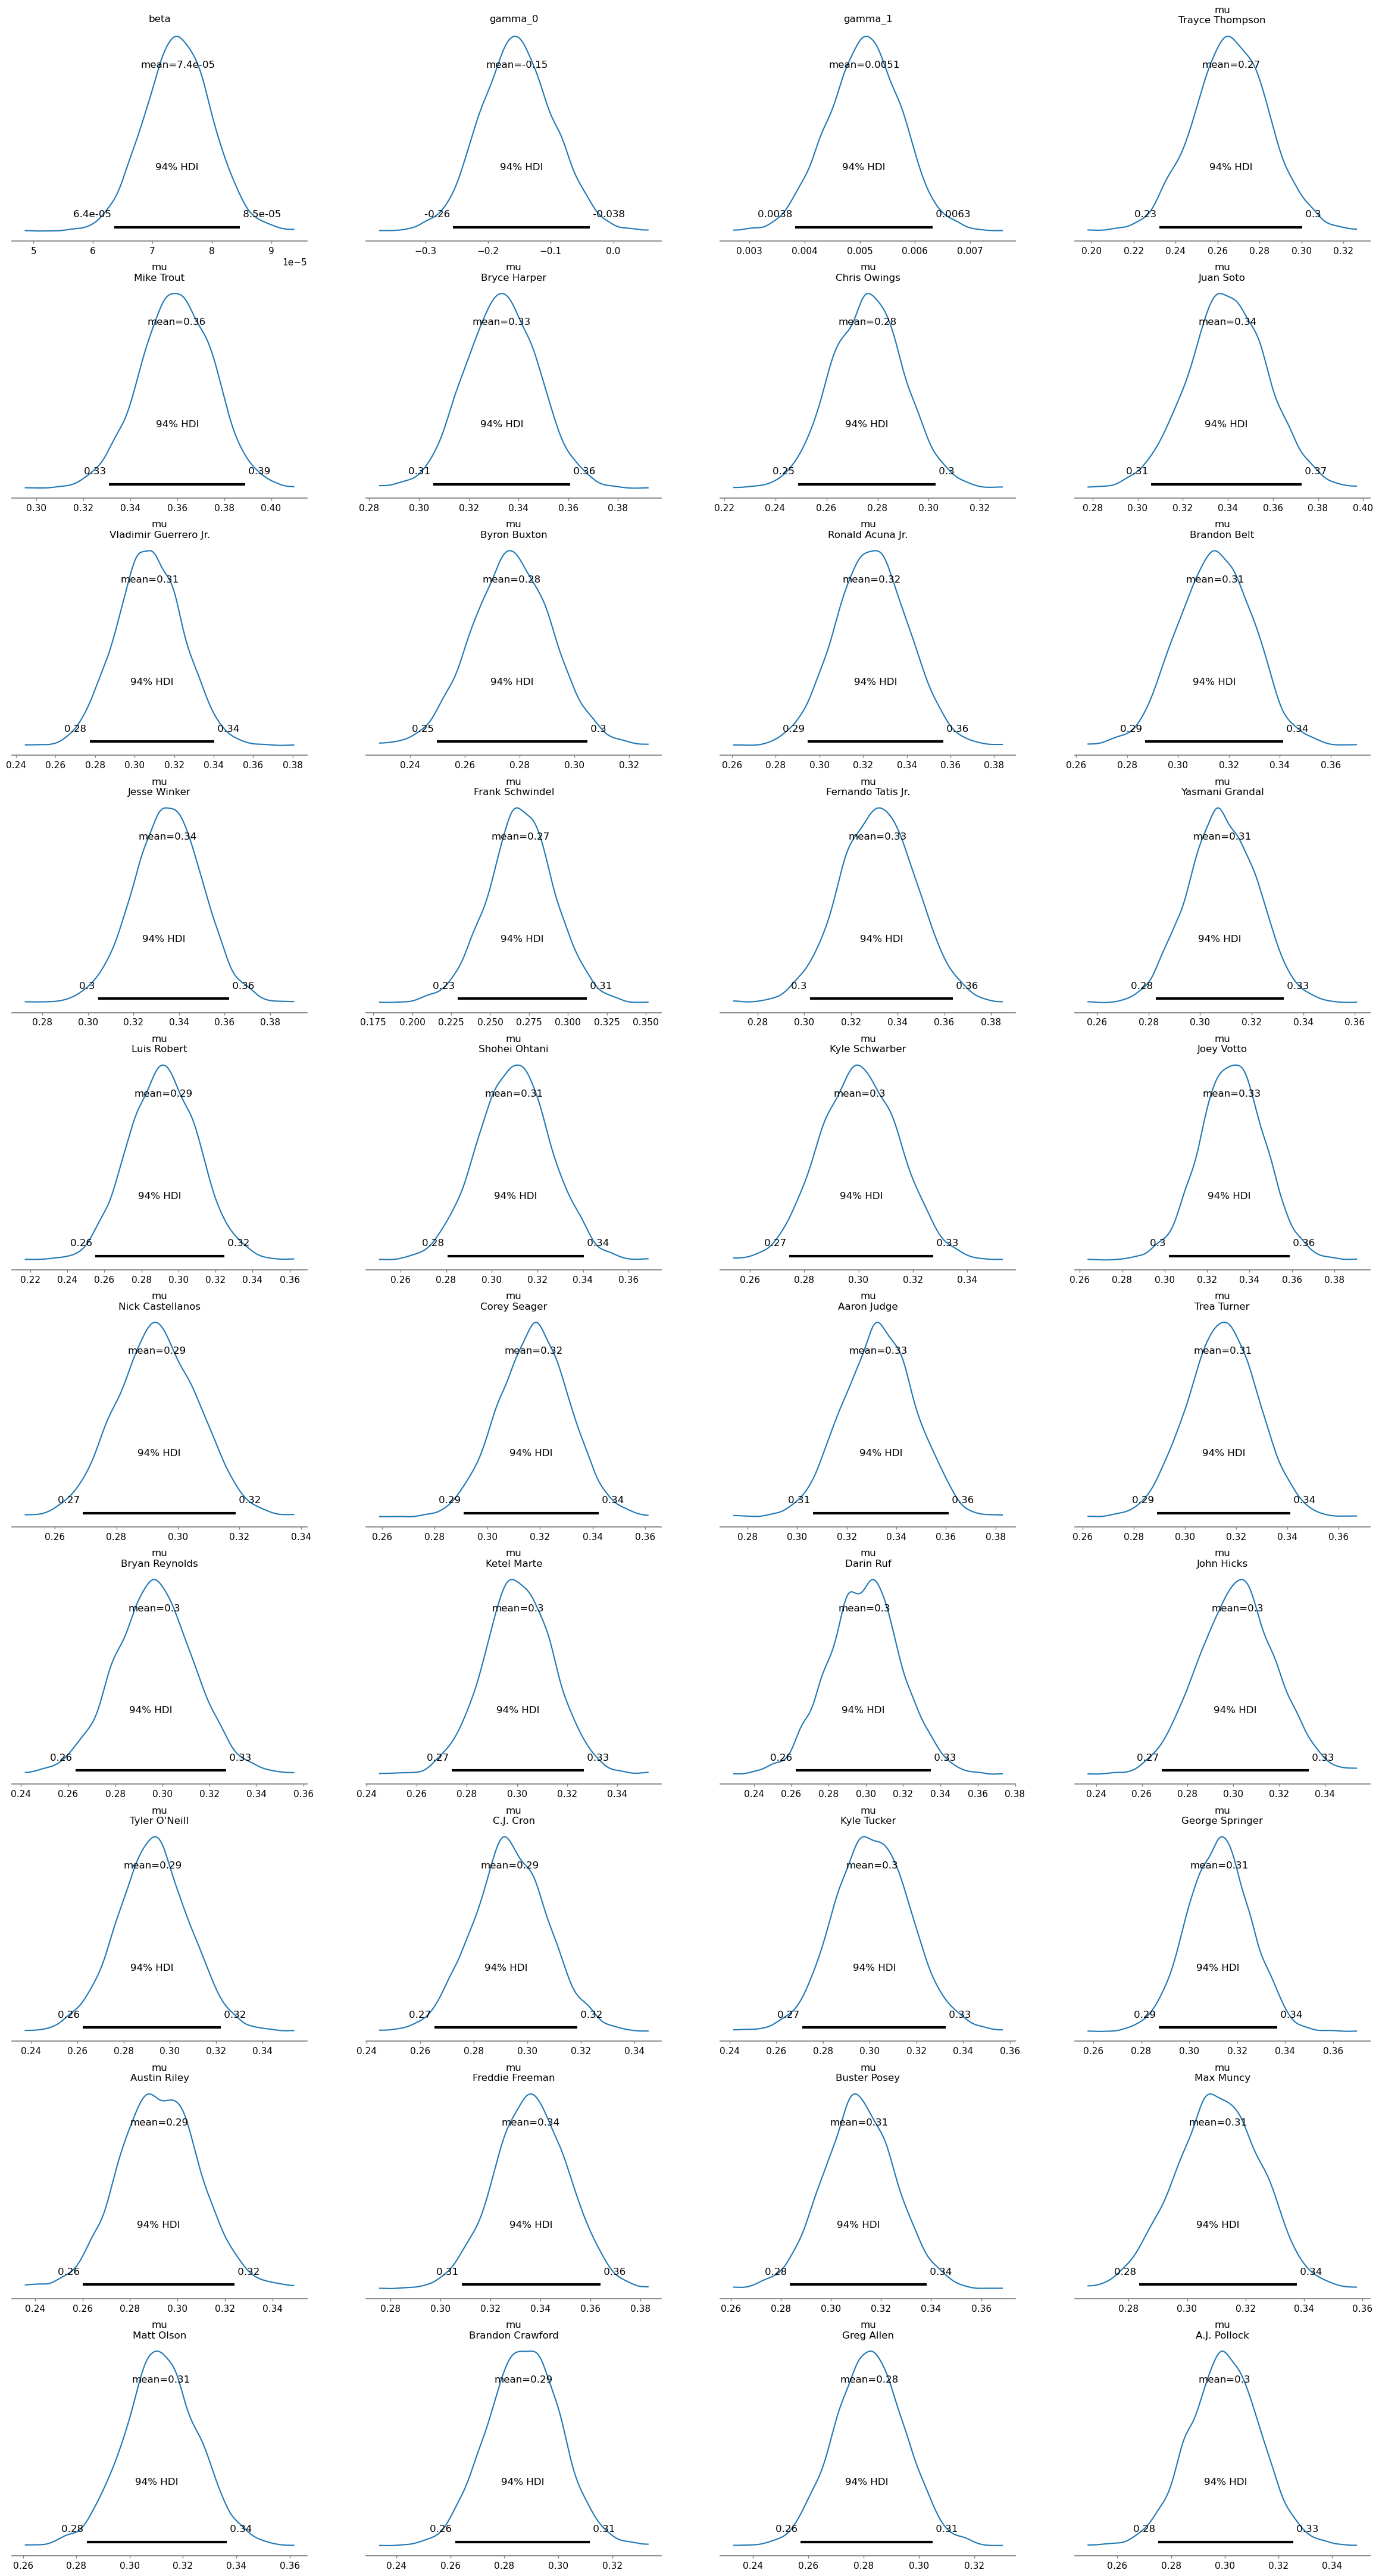

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'gamma_0'}>,
        <Axes: title={'center': 'gamma_1'}>,
        <Axes: title={'center': 'mu\nTrayce Thompson'}>],
       [<Axes: title={'center': 'mu\nMike Trout'}>,
        <Axes: title={'center': 'mu\nBryce Harper'}>,
        <Axes: title={'center': 'mu\nChris Owings'}>,
        <Axes: title={'center': 'mu\nJuan Soto'}>],
       [<Axes: title={'center': 'mu\nVladimir Guerrero Jr.'}>,
        <Axes: title={'center': 'mu\nByron Buxton'}>,
        <Axes: title={'center': 'mu\nRonald Acuna Jr.'}>,
        <Axes: title={'center': 'mu\nBrandon Belt'}>],
       [<Axes: title={'center': 'mu\nJesse Winker'}>,
        <Axes: title={'center': 'mu\nFrank Schwindel'}>,
        <Axes: title={'center': 'mu\nFernando Tatis Jr.'}>,
        <Axes: title={'center': 'mu\nYasmani Grandal'}>],
       [<Axes: title={'center': 'mu\nLuis Robert'}>,
        <Axes: title={'center': 'mu\nShohei Ohtani'}>,
        <Axes: title={'center':

In [353]:
az.plot_posterior(varying_intercept_noncentered_trace_2,show = True)

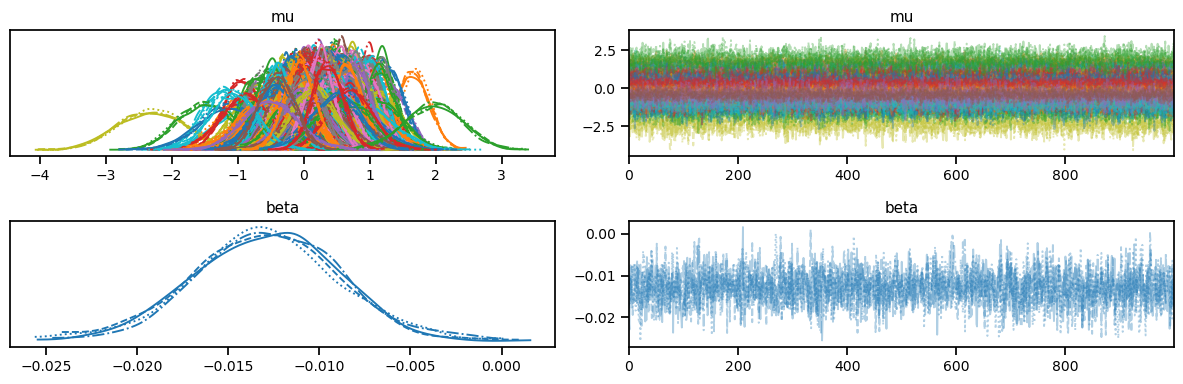

In [397]:
az.plot_trace(varying_intercept_noncentered_trace_2, var_names=['mu', 'beta','v',]);
plt.tight_layout();
plt.show()

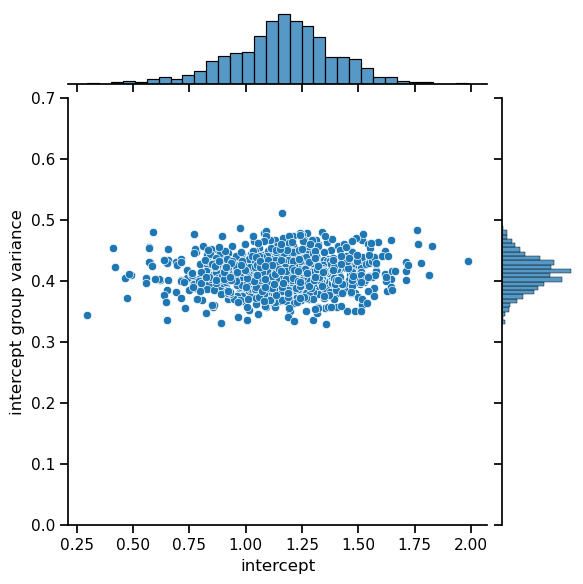

In [402]:
x = pl.Series('intercept', varying_intercept_noncentered_trace_2.posterior['mu'].sel(chain=0)[:,2].to_numpy())
y = pl.Series('intercept group variance', varying_intercept_noncentered_trace_2.posterior['sigma_a'].sel(chain=0).to_numpy())

sns.jointplot(x=x, y=y, ylim=(0, .7));
plt.show()

In [403]:
#varying_intercept_noncentered_trace_2.posterior['beta'].sel(chain=0)[:]

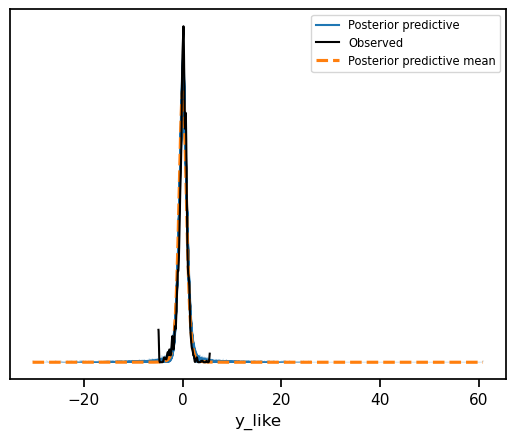

In [404]:
az.plot_ppc(varying_intercept_noncentered_trace_2,show = True);

/home/john/miniconda3/envs/BaseballHitters/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


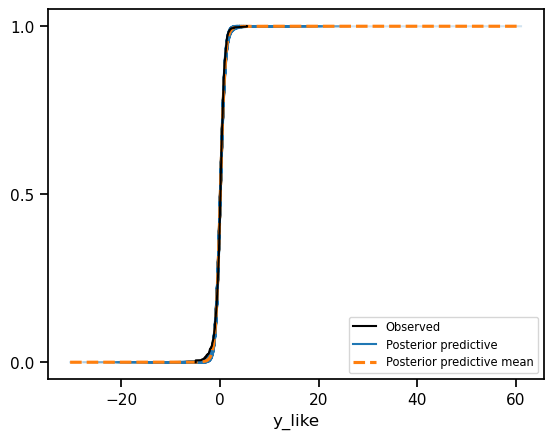

In [405]:
az.plot_ppc(varying_intercept_noncentered_trace_2, kind='cumulative',show = True);